# Transfer Learning: дообучение сети.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time
from PIL import Image
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

## Загрузка предобученной сети

Загружаем предобученный resnet из репозитория pytorch:

In [ ]:
# модель resnet-18
model = models.resnet18(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Чтобы использовать предобученную сеть resnet18 наиболее эффективно, нужно все изображения, которые мы подаем ей на вход, предобрабатывать определенным образом. Для всех сетей семейства resnet есть свои фиксированные преобразования:

In [ ]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

# можно самому не писать преобразования, а просто взять их из models:
# resnet_transforms = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

## Тест предобученной сети на одной картинке

Загрузим картинку песика из интернета:

In [ ]:
! wget "https://ichef.bbci.co.uk/news/640/cpsprodpb/475B/production/_98776281_gettyimages-521697453.jpg" -O "doggie.jpg"

--2022-07-26 16:06:18--  https://ichef.bbci.co.uk/news/640/cpsprodpb/475B/production/_98776281_gettyimages-521697453.jpg
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 23.214.81.81, 2600:1409:9800:982::f33, 2600:1409:9800:98a::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|23.214.81.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23424 (23K) [image/jpeg]
Saving to: ‘doggie.jpg’

doggie.jpg          100%[===================>]  22.88K  --.-KB/s    in 0.007s  

2022-07-26 16:06:18 (3.35 MB/s) - ‘doggie.jpg’ saved [23424/23424]



Посмотрим на картинку:

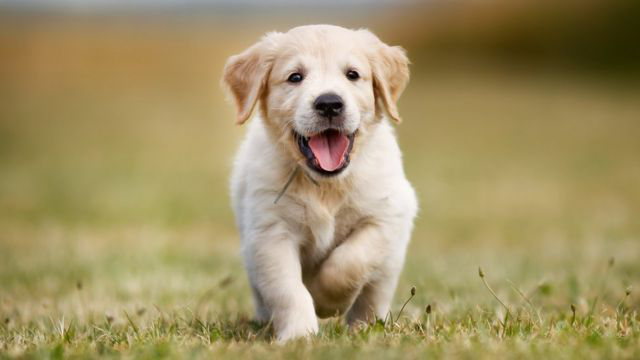

In [ ]:
from PIL import Image

image = Image.open('doggie.jpg')
image

Применим трансформации к картинке и посмотрим, как она будет после этого выглядеть:

In [ ]:
image_transformed = resnet_transforms(image)
print(image_transformed.shape)

torch.Size([3, 224, 224])


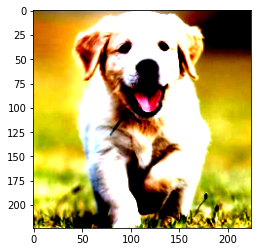

In [ ]:
plt.imshow(image_transformed.permute(1,2,0).data.cpu().numpy())

Подадим картинку на вход сети и получим ответ:

In [ ]:
model.eval()

# image_transformed -> [image_transformed]
model_output = model(image_transformed.reshape((1, 3, 224, 224)))
model_output

tensor([[ 7.7077e-01, -6.9995e-01, -2.0034e+00, -5.2627e+00, -1.6722e+00,
         -3.2275e-01, -2.7517e+00, -1.8901e+00, -5.1444e-01, -3.0016e+00,
         -2.2753e+00, -1.9177e+00, -1.4968e+00, -4.1212e+00, -8.3289e-01,
         -4.5009e+00, -4.1169e+00, -2.9564e+00, -3.9483e+00, -5.2496e+00,
         -2.1639e+00, -8.2852e-01, -1.2976e+00,  1.6536e-01,  1.7160e-01,
          2.7752e-01, -4.6772e-01, -6.9583e-01, -2.6529e-01, -2.0158e+00,
         -2.4441e+00, -3.3026e+00, -1.6058e+00, -9.9242e-01,  7.2587e-01,
          7.9776e-01,  1.1468e+00, -1.2569e+00, -1.7889e+00, -1.4945e+00,
         -1.5085e+00, -1.3316e-01, -8.2007e-01, -2.3253e+00, -5.4764e-02,
         -6.7991e-01, -1.0486e+00,  4.2400e-01, -9.9599e-01, -2.7179e+00,
         -1.1205e+00,  3.2820e-02,  1.8051e-01, -3.7453e-01, -2.2968e+00,
         -1.7933e+00, -4.0865e-01, -1.9990e+00, -1.6264e+00, -2.1370e+00,
         -1.7358e-01, -1.1359e+00, -2.1174e+00,  2.1494e-01,  5.0277e-01,
         -2.9624e+00, -1.9418e+00, -1.

Получим ответ сети на картинку. Соотношения номеров классов и названий можно посмотреть тут: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [ ]:
np.argmax(model_output.data.cpu().numpy())

207

## Дообучение сети на новом датасете

Мы будем обучать нейросеть на датасете пород собак. Ссылка: https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set

Вы можете скачать датасет на google colab с помощью двух ячеек ниже или же сделать так, как сделано у меня: загрузить датасет на свой гугл диск и подмонтировать его с помощью google.colab.drive (об этом я рассказываю в видео).

**Внимание**: если пользуетесь этим методом скачивания данных, не забудьте поменять пути к папка train, val и test при создании датасетов ниже.

In [ ]:
# эта ячейка скачивает zip архив с данными 
# ! wget "https://www.dropbox.com/s/r11z0ugf2mezxvi/dogs.zip?dl=0" -O dogs.zip

In [ ]:
# эта ячейка распаковывает архив. В колабе появится папка ./dogs с данными. 
# ! unzip dogs.zip 

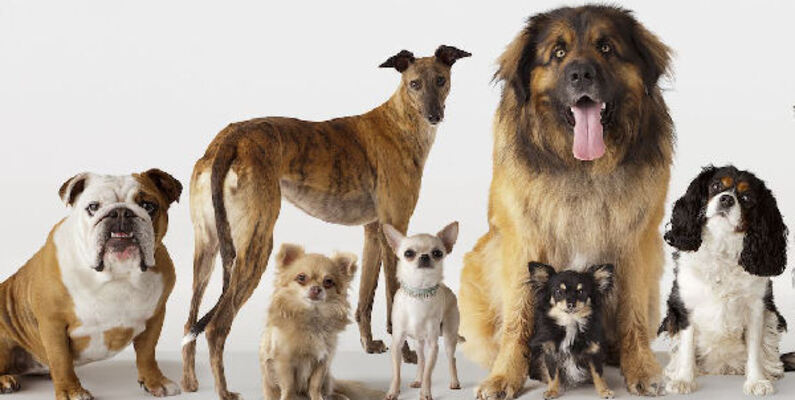

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Заведем датасеты и даталоадеры.

Для того, чтобы из папки с картинками сделать PyTorch Dataset, можно воспользоваться datasets.ImageFolder. Для этого папка с картинками должна иметь следующий вид:


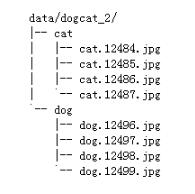


То есть, внутри папки с данными должны быть N подпапок, где N — количество классов в датасете. Каждая подпапка соответствует одному классу картинок. Название папки — название класс. Внутри папки с названием класса находятся картинки, принадлежащие этому классу.

In [ ]:
resnet_transforms = transforms.Compose([
        transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

In [ ]:
train_data = datasets.ImageFolder('', transform=resnet_transforms)
val_data = datasets.ImageFolder('', transform=resnet_transforms)
test_data = datasets.ImageFolder('', transform=resnet_transforms)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

### Заморозка весов и замена последнего слоя

In [ ]:
model = models.resnet18(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Заменим последний слой сети на новый, содержащий 70 нейронов (так как у нас 70 классов в датасете):

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(512, 70)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Заморозим все сверточные слои:

In [ ]:
len(list(model.children()))

In [ ]:
list(model.children())[5]

In [ ]:
for i, layer in enumerate(model.children()):
  if i < 9:
    for param in layer.parameters():
      param.requires_grad = False

Перенесем нашу нейросеть на GPU, если GPU доступен:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
model = model.to(device)

### Обучение сети

In [ ]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Импортируем нужные модули и пишем нужные команды для Tensorboard:

In [ ]:
import os

if not os.path.exists('logs'):
    os.mkdir('logs')

%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")

In [ ]:
%tensorboard --logdir=./logs

Функция обучения сети:

In [ ]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = len(dataloader)

    for i, batch in enumerate(dataloader):
        
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        with torch.no_grad():
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            
            y_batch = y_batch.to(device)
            loss = loss_fn(logits, y_batch)
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred == y_batch)
    
    accuracy = num_correct / num_elements
            
    return accuracy, np.mean(losses)

def train(model, loss_fn, optimizer, n_epoch=3):

    num_iter = 0
    
    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch)

        model.train(True)
        
        for i, batch in enumerate(train_loader):
            # так получаем текущий батч
            X_batch, y_batch = batch 
            
            # forward pass (получение ответов на батч картинок)
            X_batch = X_batch.to(device)
            logits = model(X_batch) 
            
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            y_batch = y_batch.to(device)
            loss = loss_fn(logits, y_batch) 
            
            
            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            #########################
            # Логирование результатов
            num_iter += 1
            writer.add_scalar('Loss/train', loss.item(), num_iter)

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers) / len(y_batch)
            writer.add_scalar('Accuracy/train', train_accuracy, num_iter)
            #########################

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)

        writer.add_scalar('Loss/val', val_loss.item(), num_iter)
        writer.add_scalar('Accuracy/val', val_accuracy, num_iter)
        
        
    return model

Обучаем сеть:

In [ ]:
model = train(model, loss_fn, optimizer, n_epoch=3)

Проверим метрику accuracy на тренировочной и тестовой выборках:

In [ ]:
train_accuracy, _ = evaluate(model, train_loader);
print('Train accuracy is', train_accuracy)

In [ ]:
test_accuracy, _ = evaluate(model, test_loader);
print('Test accuracy is', test_accuracy)

Загрузка графиков обучения на Tensorboard dev:

In [ ]:
# !tensorboard dev upload --logdir=./logs \
# --name "My latest experiment" \
# --description "Simple comparison of several hyperparameters"

## Сохранение модели

Сохранение модели:

In [ ]:
torch.save(model, 'model_dogs.pt')

Загрузка модели из сохраненного чекпоинта:

In [ ]:
model_new = torch.load('model_dogs.pt')

Проверим, что модель загрузилась и что она точно та же, что мы тестировали выше:

In [ ]:
test_accuracy, _ = evaluate(model, test_loader, name='test');
print('Test accuracy is', test_accuracy)

Загруженную модель можно, например, дообучить еще несколько эпох:

In [ ]:
model_new, train_losses, val_losses, val_accuracies = train(model_new, n_epoch=5)